In [1]:
import sys
import matplotlib.pyplot as plt
import mplfinance as mpl
import numpy as np
 
# Avoid AttributeError: module 'sqlalchemy' has no attribute 'orm'
import sqlalchemy.orm  # noqa: F401

sys.path.append("..")
from gmo_hft_bot.db.database import initialize_database
from gmo_hft_bot.db import crud
from backtest.visualize.ohlcv import ohlcv_plot
from backtest.utils.utils import get_ohlcv_df, get_predict_df, match_timestamp_for_ohlcv
from backtest.backtest_trade.richman_backtest import richman_backtest

In [3]:
symbol = "BTC_JPY"

_, SessionLocal = initialize_database(uri="sqlite:///../example.db")
with SessionLocal() as db:
    ohlcv_data = crud.get_ohlcv_with_symbol(db=db, symbol=symbol)
    predict_data = crud.get_predict_items(db=db, symbol=symbol)

# fig, axes = plt.subplots(2, 1, figsize=(16, 8))
# axes = axes.flatten()

time_span = 5
ohlcv_df = get_ohlcv_df(ohlcv_data, time_span=time_span)
buy_df, sell_df = get_predict_df(predict_data)
timestamped_buy_df = match_timestamp_for_ohlcv(ohlcv_df, buy_df, time_span)
timestamped_sell_df = match_timestamp_for_ohlcv(ohlcv_df, sell_df, time_span)

spread = timestamped_sell_df["price"] - timestamped_buy_df["price"]
spread += 200
timestamped_sell_df["price"] -= spread
timestamped_buy_df["price"] += spread

result_online = richman_backtest(ohlcv_df, buy_df=timestamped_buy_df.shift(-1), sell_df=timestamped_sell_df.shift(-1))

/Users/akiranoda/projects/gmo-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


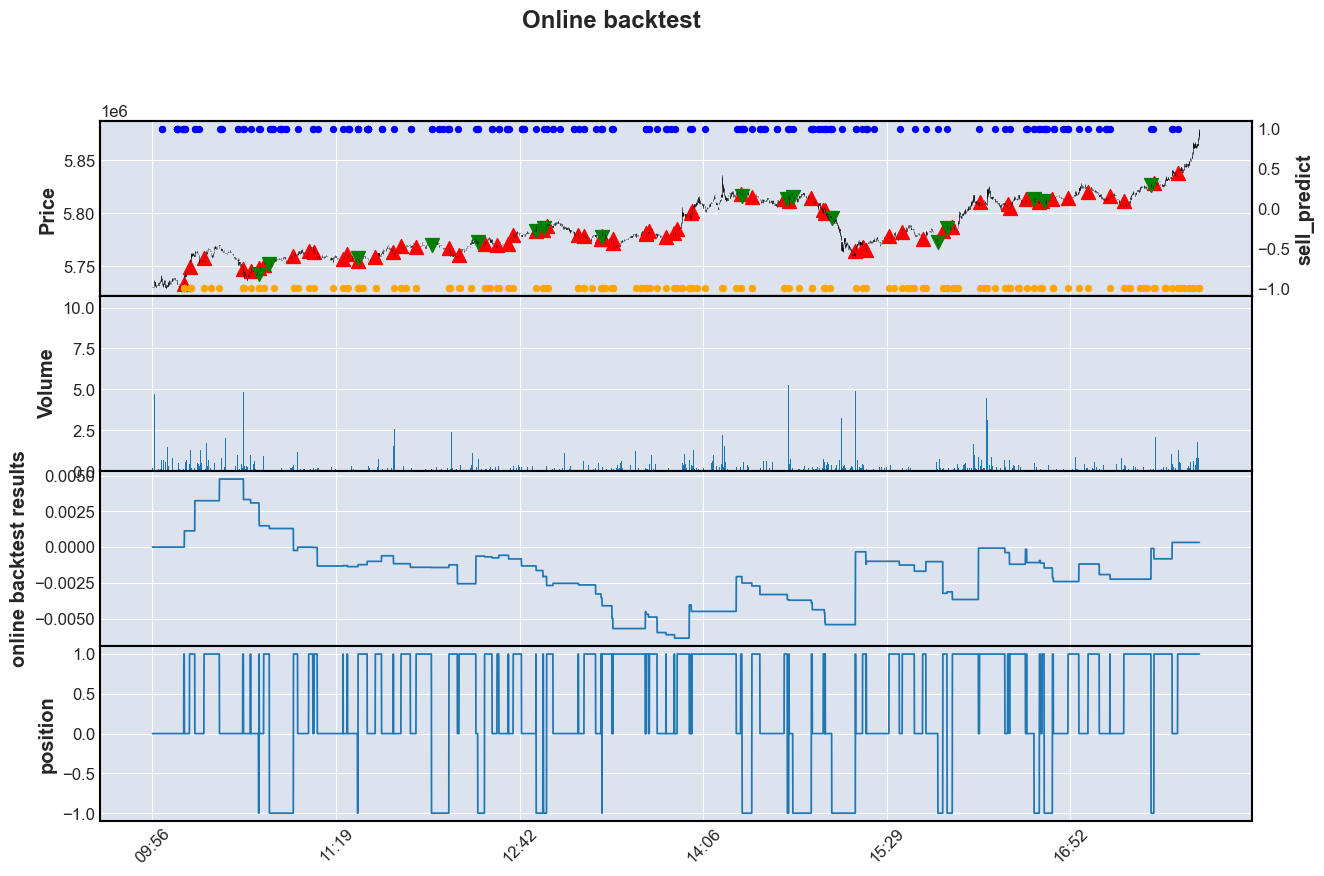

In [4]:
mpl_adds = [
    # Prediction plot
    mpl.make_addplot(np.where(timestamped_buy_df["is_entry"] == True, -1, np.nan), type="scatter", ylabel="buy_predict", color="orange", y_on_right=False),
    mpl.make_addplot(np.where(timestamped_sell_df["is_entry"] == True, 1, np.nan), type="scatter", ylabel="sell_predict", color="blue", y_on_right=False),

    # Entry plot
    mpl.make_addplot(result_online["buy_entry_price"] - 1000, type="scatter", markersize=100, marker="^", color="r"),
    mpl.make_addplot(result_online["sell_entry_price"] + 1000, type="scatter", markersize=100, marker="v", color="g"),

    # Volume plot
    mpl.make_addplot(ohlcv_df["volume"], type="bar", panel=1, ylabel="Volume", y_on_right=False),

    # Cumulative plot
    mpl.make_addplot(result_online["cumulative_return"], type="line", panel=2, ylabel="online backtest results", y_on_right=False),

    # Position plot
    mpl.make_addplot(result_online["position"], type="line", panel=3, ylabel="position", y_on_right=False),
]
mpl.plot(ohlcv_df, type="candle", addplot=mpl_adds, figsize=(16, 10), panel_ratios=(1,1), figratio=(1,1), figscale=1.5, title="Online backtest")
plt.close()

In [5]:
# local data backtest
local_timestamped_buy_df = timestamped_buy_df.copy()
local_timestamped_sell_df = timestamped_sell_df.copy()
pips = 100
local_timestamped_buy_df['price'] = ohlcv_df.loc[:,'close'] - pips
local_timestamped_sell_df['price'] = ohlcv_df.loc[:,'close'] + pips
result_local = richman_backtest(ohlcv_df, buy_df=local_timestamped_buy_df.shift(-1), sell_df=local_timestamped_sell_df.shift(-1))

/Users/akiranoda/projects/gmo-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


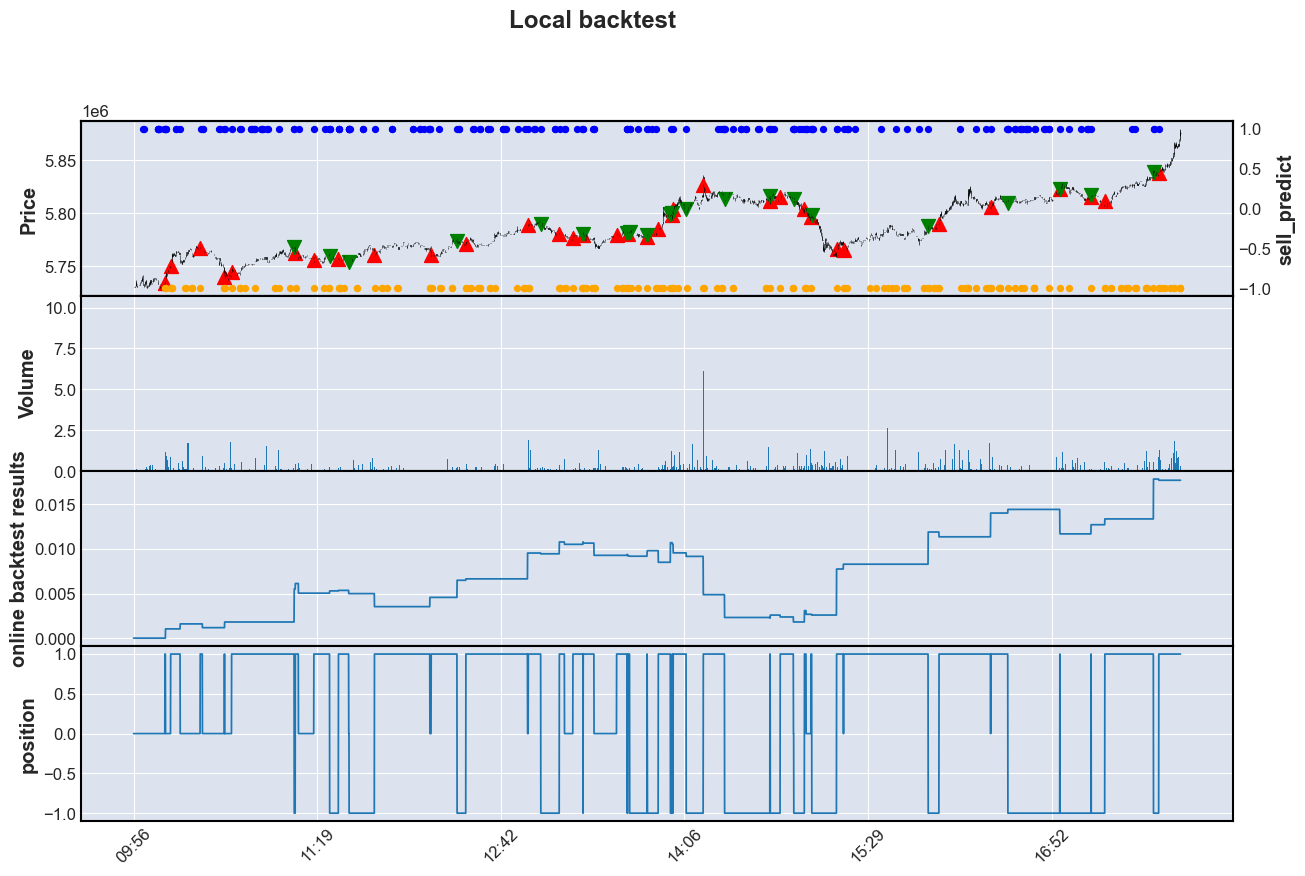

In [6]:
mpl_adds = [
    # Prediction plot
    mpl.make_addplot(np.where(timestamped_buy_df["is_entry"] == True, -1, np.nan), type="scatter", ylabel="buy_predict", color="orange", y_on_right=False),
    mpl.make_addplot(np.where(timestamped_sell_df["is_entry"] == True, 1, np.nan), type="scatter", ylabel="sell_predict", color="blue", y_on_right=False),

    # Entry plot
    mpl.make_addplot(result_local["buy_entry_price"] - 1000, type="scatter", markersize=100, marker="^", color="r"),
    mpl.make_addplot(result_local["sell_entry_price"] + 1000, type="scatter", markersize=100, marker="v", color="g"),

    # Volume plot
    mpl.make_addplot(ohlcv_df["volume"], type="bar", panel=1, ylabel="Volume", y_on_right=False),

    # Cumulative plot
    mpl.make_addplot(result_local["cumulative_return"], type="line", panel=2, ylabel="online backtest results", y_on_right=False),

    # Position plot
    mpl.make_addplot(result_local["position"], type="line", panel=3, ylabel="position", y_on_right=False),
]
mpl.plot(ohlcv_df, type="candle", addplot=mpl_adds, figsize=(16, 10), panel_ratios=(1,1), figratio=(1,1), figscale=1.5, title="Local backtest")
plt.close()

In [ ]:
pips = 500
ohlcv_df["local_buy_price"] = ohlcv_df["close"] - pips
merged_buy_df = timestamped_buy_df.merge(ohlcv_df["local_buy_price"], right_index=True, left_index=True)
merged_buy_df["subt_online_local"] = merged_buy_df["price"] - merged_buy_df["local_buy_price"]
merged_buy_df[['price', "local_buy_price", "subt_online_local"]].tail(30)

,price,local_buy_price,subt_online_local
timestamp,,,
2022-03-28 09:24:35+00:00,5716576.0,5715830.0,746.0
2022-03-28 09:24:40+00:00,5716169.0,5715357.0,812.0
2022-03-28 09:24:45+00:00,5715931.0,5715126.0,805.0
2022-03-28 09:24:50+00:00,5715204.0,5714202.0,1002.0
2022-03-28 09:24:55+00:00,5714925.0,5713495.0,1430.0
2022-03-28 09:25:00+00:00,5714095.0,5715130.0,-1035.0
2022-03-28 09:25:05+00:00,5713876.0,5715516.0,-1640.0
2022-03-28 09:25:10+00:00,5716059.0,5716766.0,-707.0
2022-03-28 09:25:15+00:00,5717374.0,5716785.0,589.0


In [ ]:
ohlcv_df.head(20)

,open,high,low,close,volume,local_buy_price
timestamp,,,,,,
2022-03-27 20:42:25+00:00,5440582.0,5440582.0,5440582.0,5440582.0,0.18,5440082.0
2022-03-27 20:42:30+00:00,5440582.0,5440582.0,5440582.0,5440582.0,0.00,5440082.0
2022-03-27 20:42:35+00:00,5439695.0,5439695.0,5439500.0,5439500.0,0.22,5439000.0
2022-03-27 20:42:40+00:00,5439500.0,5439500.0,5439500.0,5439500.0,0.00,5439000.0
2022-03-27 20:42:45+00:00,5439500.0,5439500.0,5439500.0,5439500.0,0.00,5439000.0
2022-03-27 20:42:50+00:00,5439500.0,5439500.0,5439500.0,5439500.0,0.00,5439000.0
2022-03-27 20:42:55+00:00,5439500.0,5439500.0,5439500.0,5439500.0,0.00,5439000.0
2022-03-27 20:43:00+00:00,5439500.0,5439500.0,5439500.0,5439500.0,0.00,5439000.0
2022-03-27 20:43:05+00:00,5439500.0,5439500.0,5439500.0,5439500.0,0.00,5439000.0


In [ ]:
ohlcv_df["std_vol"] = ohlcv_df["volume"].rolling(10).std()
print(ohlcv_df["std_vol"][0])
ohlcv_df[50:].head(50)

nan


,open,high,low,close,volume,std_vol
timestamp,,,,,,
2022-03-28 05:31:35+00:00,5471690.0,5471690.0,5471690.0,5471690.0,0.01,0.231039
2022-03-28 05:31:40+00:00,5471690.0,5471690.0,5471690.0,5471690.0,0.00,0.231039
2022-03-28 05:31:45+00:00,5471743.0,5471743.0,5471743.0,5471743.0,0.02,0.229649
2022-03-28 05:31:50+00:00,5472688.0,5472688.0,5472688.0,5472688.0,0.04,0.229010
2022-03-28 05:31:55+00:00,5474141.0,5474141.0,5474141.0,5474141.0,0.02,0.231442
2022-03-28 05:32:00+00:00,5475067.0,5475197.0,5475000.0,5475197.0,0.12,0.231000
2022-03-28 05:32:05+00:00,5476905.0,5478200.0,5476120.0,5476120.0,1.44,0.476376
2022-03-28 05:32:10+00:00,5475880.0,5483014.0,5475880.0,5479490.0,6.50,2.021507
2022-03-28 05:32:15+00:00,5476276.0,5478846.0,5476241.0,5478846.0,0.84,2.003260


In [ ]:
std20 = ohlcv_df["close"].rolling(20).std()
ohlcv_df["bb_upper"] = (ohlcv_df["close"] + std20 * 2.0).rolling(5).mean()
ohlcv_df["bb_lower"] = (ohlcv_df["close"] - std20 * 2.0).rolling(5).mean()

ohlcv_df["std_vol"] = ohlcv_df["volume"].rolling(15).std()
ohlcv_df[90:].head(50)

,open,high,low,close,volume,std_vol,up_candle,bb_upper,bb_lower
timestamp,,,,,,,,,
2022-03-28 05:34:55+00:00,5491940.0,5493152.0,5491940.0,5493152.0,0.03,0.187243,0.000221,5.496741e+06,5.485646e+06
2022-03-28 05:35:00+00:00,5493152.0,5495207.0,5493002.0,5495207.0,0.50,0.202797,0.000374,5.498161e+06,5.486636e+06
2022-03-28 05:35:05+00:00,5493450.0,5495030.0,5493210.0,5495030.0,0.87,0.260353,0.000288,5.499569e+06,5.487566e+06
2022-03-28 05:35:10+00:00,5493282.0,5494590.0,5492606.0,5493911.0,0.72,0.282258,0.000115,5.499991e+06,5.487750e+06
2022-03-28 05:35:15+00:00,5494999.0,5503820.0,5494734.0,5503820.0,6.28,1.574232,0.001605,5.502929e+06,5.489519e+06
2022-03-28 05:35:20+00:00,5503820.0,5530500.0,5503508.0,5527909.0,18.17,4.779323,0.004377,5.512440e+06,5.493911e+06
2022-03-28 05:35:25+00:00,5527909.0,5547620.0,5521019.0,5532985.0,11.16,5.309643,0.000918,5.523891e+06,5.497571e+06
2022-03-28 05:35:30+00:00,5533695.0,5536909.0,5518816.0,5526860.0,5.74,5.318534,-0.001235,5.534846e+06,5.499348e+06
2022-03-28 05:35:35+00:00,5527391.0,5537871.0,5523566.0,5534284.0,6.28,5.319088,0.001247,5.548352e+06,5.501991e+06


In [ ]:
timestamped_buy_df[90:].head(50)

,side,price,size,predict_value,symbol,is_entry,acutual_timestamp
timestamp,,,,,,,
2022-03-28 05:34:55+00:00,BUY,5491699.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:55.016000+00:00
2022-03-28 05:35:00+00:00,BUY,5491740.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:35:00.020000+00:00
2022-03-28 05:35:05+00:00,BUY,5493230.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:35:05.017000+00:00
2022-03-28 05:35:10+00:00,BUY,5493889.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:35:10.025000+00:00
2022-03-28 05:35:15+00:00,BUY,5494353.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:35:15.017000+00:00
2022-03-28 05:35:20+00:00,BUY,5500009.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:35:20.055000+00:00
2022-03-28 05:35:25+00:00,BUY,5521119.0,0.01,1.0,BTC_JPY,True,2022-03-28 05:35:25.814000+00:00
2022-03-28 05:35:30+00:00,BUY,5533609.0,0.01,1.0,BTC_JPY,True,2022-03-28 05:35:30.518000+00:00
2022-03-28 05:35:35+00:00,BUY,5521996.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:35:35.325000+00:00


In [ ]:
timestamped_sell_df[80:150].head(50)

,side,price,size,predict_value,symbol,is_entry,acutual_timestamp
timestamp,,,,,,,
2022-03-28 05:34:05+00:00,SELL,5488131.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:05.020000+00:00
2022-03-28 05:34:10+00:00,SELL,5488117.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:10.019000+00:00
2022-03-28 05:34:15+00:00,SELL,5488115.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:15.018000+00:00
2022-03-28 05:34:20+00:00,SELL,5489980.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:20.022000+00:00
2022-03-28 05:34:25+00:00,SELL,5489980.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:25.018000+00:00
2022-03-28 05:34:30+00:00,SELL,5490817.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:30.020000+00:00
2022-03-28 05:34:35+00:00,SELL,5491278.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:35.021000+00:00
2022-03-28 05:34:40+00:00,SELL,5490979.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:40.018000+00:00
2022-03-28 05:34:45+00:00,SELL,5491920.0,0.01,0.0,BTC_JPY,False,2022-03-28 05:34:45.020000+00:00


In [ ]:
result_online[80:].head(50)

,cumulative_return,position,buy_entry_price,sell_entry_price,buy_exit_price,sell_exit_price
timestamp,,,,,,
2022-03-28 05:34:05+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
2022-03-28 05:34:10+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
2022-03-28 05:34:15+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
2022-03-28 05:34:20+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
2022-03-28 05:34:25+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
2022-03-28 05:34:30+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
2022-03-28 05:34:35+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
2022-03-28 05:34:40+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
2022-03-28 05:34:45+00:00,0.000000,1.0,NaN,NaN,NaN,NaN
